In [912]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt

import requests
from lxml import html

from BeautifulSoup import BeautifulSoup as BS
import urllib2
import re

import pandas as pd
import numpy as np
import string
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data assembly

In [798]:
def years_2005_13(year,month,day,name,age):
    '''
    apply only to years 2005 to 2013 due to website format

    '''
    year_list = ['2001','2002','2003','2004','2005',
                 '2006','2007','2008','2009','2010','2011','2012']
    #year_list = ['2009']
    
    month_dict = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,
               'APRIL':4,'MAY':5,'JUNE':6,
               'JULY':7,'AUGUST':8,'SEPTEMBER':9,
               'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12,
             'January':1,'February':2,'March':3,
               'April':4,'May':5,'June':6,
               'July':7,'August':8,'September':9,
               'October':10,'November':11,'December':12}
    
    for i in year_list:
        #access webpage and save HTML into python
        page = requests.get("http://fiftiesweb.com/dead/dead-people-{}/".format(i)).text
        soup = BS(page)
    
        #Loop celbs and save to dates to lists
        elem_p = soup.findAll('p')[1:]
        elem = soup.findAll('b')[1:]
    
        for j in range(len(elem)):
            try:
                year_j = i
                celeb_j = elem[j].text[:-1]
                date_elem = str(elem_p[j].text[0:20])
                month_j = month_dict[string.split(date_elem,' ')[0]]
                day_j = string.split(date_elem,' ')[1]
                try:
                    day_j = string.split(day_j,'-')[0]
                except:
                    pass       
                
                try:
                    age_j = string.split(str(elem_p[j].text[-4:]),' ')[1]
                except:
                    age_j = 'nan'
                
                #print year_j, month_j, day_j, celeb_j, age_j
                year.append(year_j)
                month.append(month_j)
                day.append(day_j)
                name.append(celeb_j)
                age.append(age_j)
            except:
                pass
    return year,month,day,name,age

In [799]:
def years_2013_16(year,month,day,name,age):
    '''
    apply only to years 2013 to 2016 due to website format

    '''
    year_list = ['2013','2014','2015','2016']
    #year_list = ['2015']
    
    month_dict = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,
               'APRIL':4,'MAY':5,'JUNE':6,
               'JULY':7,'AUGUST':8,'SEPTEMBER':9,
               'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12,
               'January':1,'February':2,'March':3,
               'April':4,'May':5,'June':6,
               'July':7,'August':8,'September':9,
               'October':10,'November':11,'December':12,
                'October-':10,'November-':11,'December-':12,
                'Celebrity Deaths 2016JANUARY':1}
    
    for i in year_list:
        #access webpage and save HTML into python
        page = requests.get("http://fiftiesweb.com/dead/dead-people-{}/".format(i)).text
        soup = BS(page)
    
        #Loop celbs and save to dates to lists
        elem_p = soup.findAll('p')[1:]
        elem = soup.findAll('b')
        #print elem_p
        
    
        for j in range(len(elem_p)):
            year_j = i
            try:
                k = str(elem_p[j].text[0:30])
                month_b = k in month_dict.keys()
                if (month_b == True):
                    month_j = month_dict[k]
                else:
                    if (elem_p[j].text[0] == '0'):
                        day_j = elem_p[j].text[1]
                    else:
                        day_j = elem_p[j].text[0:2]

                name_elem_b = str(string.split(k,',')[0])
                celeb_j = string.split(name_elem_b,';')[1]

                try:
                    age_j = string.split(str(elem_p[j].text[-4:]),' ')[1]
                except:
                    age_j = 'nan'

                
                #print year_j, month_j, day_j, celeb_j
                year.append(year_j)
                month.append(month_j)
                day.append(day_j)
                name.append(celeb_j)
                age.append(age_j)
            except:
                pass

    return year,month,day,name,age



In [800]:
#lists
year = []
month = []
day = []
name = []
age = []

      
year,month,day,name,age = years_2005_13(year,month,day,name,age)
year,month,day,name,age = years_2013_16(year,month,day,name,age)

In [801]:
#soup

In [802]:
def func(x):
    try:
        x = int(x)
    except:
        x = 'nan'
    return x

year = map(lambda x: func(x),year)
month = map(lambda x: func(x),month)
day = map(lambda x: func(x),day)
age = map(lambda x: func(x),age)

dict = {'year':year,
        'month':month,
        'day':day,
        'name':name,
        'age':age}

df = pd.DataFrame(data=dict)
print len(df)
df  = df.drop(df.day[df.day == 'nan'].index)
#df.to_csv('data/dead_celebs_2013_16.csv')
print len(df)
df.head()

964
960


,age,day,month,name,year
0,89,15,1,Ruth Warrick,2005
1,84,17,1,Virginia Mayo,2005
2,86,22,1,Rose Mary Woods,2005
3,79,23,1,Johnny Carson,2005
4,69,25,1,Ray Peterson,2005


# Analysis and visualise

In [876]:
counts = []
dates = []
dates_2 = []
#months_2 = []
#years_2 = []

years = df.year.unique()
months = df.month.unique()

c = 0 

for i in years:
    dg = df.groupby('year').get_group(i)
    for j in months:
        try:
            dh = dg.groupby('month').get_group(j)
            l = len(dh)
        except:
            l = 0
        #print "{}-{}".format(i,j)
        counts.append(l)
        dates.append("{}-{}".format(i,j))
        #months_2.append(j)
        #years_2.append(i)
        if (c%10 == 0):
            dates_2.append("{}-{}".format(i,j))
        else:
            dates_2.append(" ")
        c = c+1
        #counts["{}-{}".format(i,j)] = len(dh)

dict = {'dates':dates,
        'count':counts}

df_counts = pd.DataFrame(data=dict)
df_counts.set_index(pd.DatetimeIndex(df_counts['dates']),inplace=True)
df_counts.fillna(0,inplace=True)
del df_counts['dates']

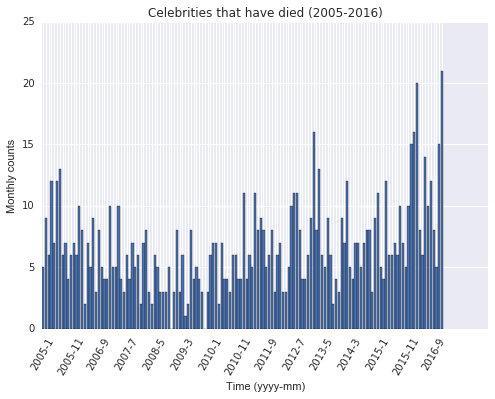

In [861]:
plt.figure()

N = len(counts)
ind = np.arange(N)
w = 0.35

x = dates_2

plt.bar(ind,df_counts['count'])

plt.title('Celebrities that have died (2005-2016)')
plt.ylabel('Monthly counts')
plt.xlabel('Time (yyyy-mm)')
plt.xticks()
plt.xticks(ind+w,x,rotation=60)

plt.show()

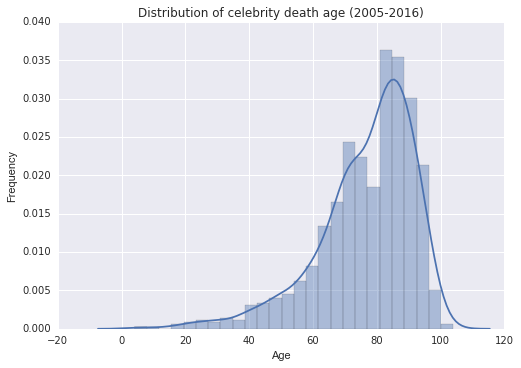

In [825]:
#plt.figure()
df_crop_age  = df.drop(df.age[df.age == 'nan'].index)
#df_crop_age.age.hist(bins=30)
#print df_crop_age.age.median(),df_crop_age.age.std()
sns.distplot(df_crop_age.age)
plt.title('Distribution of celebrity death age (2005-2016)')
plt.ylabel('Frequency')
plt.xlabel('Age')

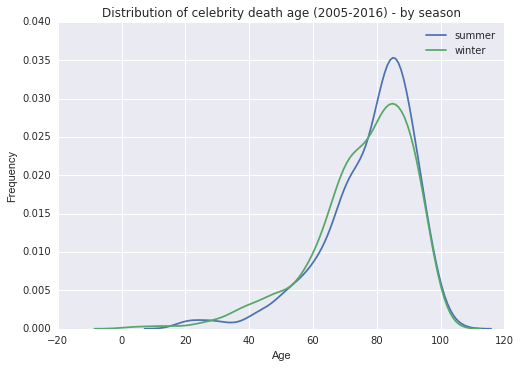

In [848]:
df_summer = df_crop_age.loc[df['month'].isin([4,5,6,7,8,9])]
df_winter = df_crop_age.loc[df['month'].isin([1,2,3,10,11,12])]

sns.kdeplot(df_summer.age,label='summer')
sns.kdeplot(df_winter.age,label='winter')

plt.title('Distribution of celebrity death age (2005-2016) - by season')
plt.ylabel('Frequency')
plt.xlabel('Age')

#sns.violinplot(df_crop_age.age)#, df_winter.age])

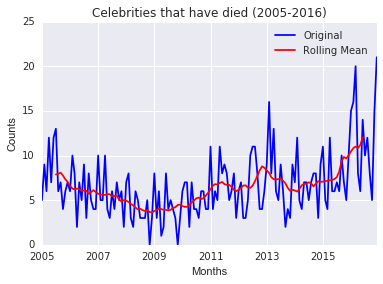

In [910]:
#TS = np.log(df_counts)
TS = df_counts

#rolmean = pd.rolling_mean(TS, window=12)
#expmean = pd.ewma(TS, halflife=12)

decomposition = seasonal_decompose(TS, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

reduced=TS-trend

#Plot rolling statistics:
orig = plt.plot(TS, color='blue',label='Original')
mean = plt.plot(trend, color='red', label='Rolling Mean')
#reduced = plt.plot(reduced, color='green', label='Reduced')

plt.title('Celebrities that have died (2005-2016)')
plt.ylabel('Counts')
plt.xlabel('Months')
plt.legend()

In [951]:
#Stationary time series
reducedTS=TS-trend
reducedTS.dropna(inplace=True)
model = ARIMA(reducedTS, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  

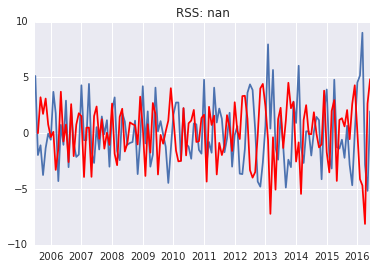

In [953]:
plt.plot(reducedTS)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-reducedTS.count())**2))

In [ ]:
#Wikipidia version (more difficult)
html = urllib2.urlopen("https://en.wikipedia.org/wiki/Deaths_in_2016")
soup = BS(html)
elem = soup.findAll('li')
print elem[33].text